In [1]:
import numpy as np

import jax.numpy as jnp
from jax import jit, vmap, grad
import jax.random

import scipy.stats
import matplotlib.pyplot as plt

In [142]:
title = "# Fisher, Hamilton Monte Carlo, and JAX"
# Print title and setup TeX defs for both KaTeX and MathJax
import bayesian_stats_course_tools
bayesian_stats_course_tools.misc.display_markdown_and_setup_tex(title)

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

# Fisher, Hamilton Monte Carlo, and JAX

<!-- Define LaTeX macros -->
$\def\E{\operatorname{E}}$
$\def\Var{\operatorname{Var}}$
$\def\Cov{\operatorname{Cov}}$
$\def\dd{\mathrm{d}}$
$\def\ee{\mathrm{e}}$
$\def\Norm{\mathcal{N}}$
$\def\Uniform{\mathcal{U}}$

<!-- MathJax needs them to be defined again for the non-inline environment -->
$$\def\E{\operatorname{E}}$$
$$\def\Var{\operatorname{Var}}$$
$$\def\Cov{\operatorname{Cov}}$$
$$\def\dd{\mathrm{d}}$$
$$\def\ee{\mathrm{e}}$$
$$\def\Norm{\mathcal{N}}$$
$$\def\Uniform{\mathcal{U}}$$

## Fisher matrix

For a distribution $p(X | \theta)$ of a RV $X$, given a parameter $\theta$, the Fisher information tells us how much information $X$ can give us about $\theta$.

The Fisher information is defined as
\begin{align}
    I(\theta) &= \E_{p(X|\theta)}\left[\left.\left(\frac{\partial\log p(X|\theta)}{\partial\theta}\right)^2 \right| \theta\right] \\
    &=^* -\E_{p(X|\theta)}\left[\left.\frac{\partial^2 \log p(X|\theta)}{\partial\theta^2}\right|\theta\right]\ .
\end{align}
The second equality applies in most cases of relevance.

#### Example: 1d Gaussian with known variance

Let
$$
    \log p(X | \mu) = -\frac{1}{2}\frac{(X - \mu)^2}{\sigma^2} + \text{const}
$$
then
$$
    I(\mu) = \frac{1}{\sigma^2}
$$

Larger $\sigma$ means less information gained on $\mu$ by data $X$.


### Cramer-Rao bound

The variance of an estimator $\hat\theta$ is bounded from below by the inverse of the Fisher information for that parameter:
$$
    \Var[\hat\theta] \geq \frac{1}{I(\theta)}
$$
For $n$ idd Gaussian $\vec X\sim \Norm(\mu, \sigma^2 I_n)$, with known variance $\sigma^2$ and unknown mean $\mu$
$$
    \log p(\vec X |\mu) = -\frac{1}{2}\sum_i \frac{(X_i - \mu)^2}{\sigma^2} + \text{const}
$$
The Fisher informaton on $\mu$ is
$$
    I(\mu) = \frac{n}{\sigma^2}
$$
The Cramer-Rao bound is therefore
$$
    \Var[\hat\mu] \geq \frac{\sigma^2}{n}
$$
The means that the variance of the sample mean is the lowest possible possible variance of an estimator for the mean.



### Multivariate case

For multiple parameters $\vec\theta$, the generalisation is the Fisher information matrix
\begin{align}
    I_{ij}(\vec\theta) &= \E_{p(X|\vec\theta)}\left[\left.\left(\frac{\partial \log p(X|\vec\theta)}{\partial \theta_i}\right)\left(\frac{\partial\log p(X|\vec\theta)}{\partial \theta_j}\right)\right|\theta\right] \\
    &= -\E_{p(X|\vec\theta)}\left[\left.\frac{\partial^2 \log p(X|\vec\theta)}{\partial \theta_i\partial\theta_j}\right|\theta\right]
\end{align}

We can get the covariance of the parameters $\vec\theta$ by taking the inverse of the Fisher information matrix. 

This allows us to make predictions on what the constraints on the parameters are going to be before we take data. 

This is only exact in the case of Gaussian distributed parameters but even if not this is a useful tool to get an idea on what an experimental setup (as encoded in the likelihood) is expected to produce.

For the case of a Gaussian likelihood where the covariance $\Sigma$ does not depend on the parameters, this reduces to
$$
    I_{ij}(\vec\theta) = \sum_{kl}\frac{\partial\mu_k(\vec\theta)}{\partial\theta_i}(\Sigma^{-1})_{kl}\frac{\partial\mu_l(\vec\theta)}{\partial\theta_j}
$$

### Jeffreys prior

Another place where the Fisher information appears is the Jeffreys priors.

We have talked about uninformative priors a couple of times so far. 
We choose uninformative priors when we do not want our posteriors to be influenced by our choice of priors.

But what does uninformative mean? 

A flat prior in $\theta$ will not be flat for $\theta^2$ for example:

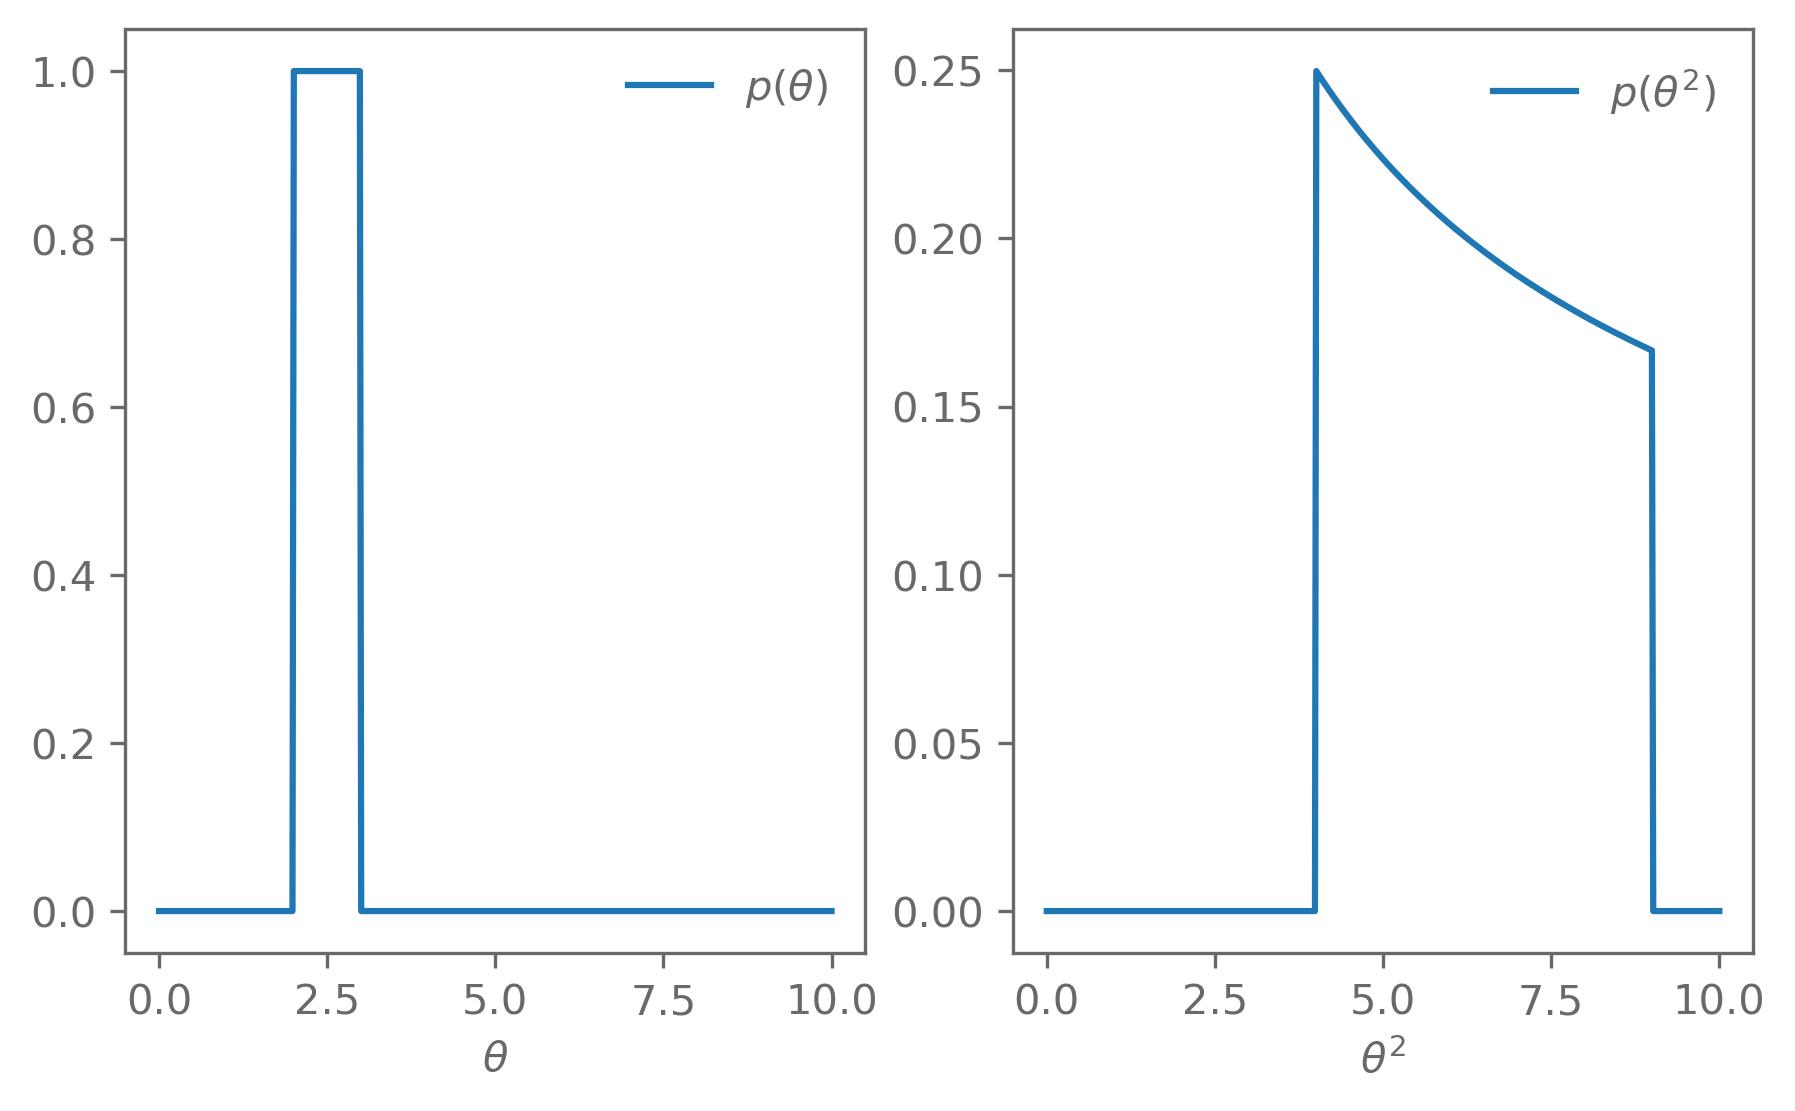

In [164]:
a, b = 2, 3
u = np.random.uniform(a, b, 10000)

fig, ax = plt.subplots(1, 2)

x = np.linspace(0, 10, 500)

p_u = np.piecewise(x, [(a < x) & (x < b)], [lambda x: 1/(b-a), 0])
p_u2 = np.piecewise(
    x, [(a < np.sqrt(x)) & (np.sqrt(x) < b)],
    [lambda x: 0.5*1/(b-a)/np.sqrt(x), 0]
)

ax[0].plot(x, p_u, label=r"$p(\theta)$")
ax[0].set_xlabel(r"$\theta$")
ax[0].legend()
ax[1].plot(x, p_u2, label=r"$p(\theta^2)$")
ax[1].set_xlabel(r"$\theta^2$")
ax[1].legend();

Jeffreys priors address this, as they are constructed such that they are invariant to reparameterisation.

$$
    p(\theta) \propto \sqrt{\det I(\theta)}
$$

This works, because under a reparameterisation $\theta \rightarrow \rho$, the Fisher information transforms as
$$
    I(\rho) = I(\theta)\left(\frac{\dd \theta}{\dd\rho}\right)^2\ ,
$$
while the the change of variables transforms the distribution $p(\theta)$ as
$$
    p(\rho) = p(\theta)\left|\frac{\dd\theta}{\dd\rho}\right|\ .
$$
By choosing $p(\theta) \propto \sqrt{\det I(\theta)}$, we also have $p(\rho) \propto \sqrt{\det I(\rho)}$, the invariance to reparameterisation we are looking for.


#### Example: Jeffreys prior for mean and variance

As we have seen before, the Fisher information of the mean of Gaussian is
$$
    I(\mu) = \frac{1}{\sigma^2}
$$
The Jeffreys prior for $\mu$ is therefore
$$
    p(\mu) \propto \frac{1}{\sigma} \propto \text{const}\ ,
$$
i.e., it does not depend on $\mu$. So for the mean (or location parameters in general), a flat prior is appropriate.

Note that the constant prior is not a probability distribution, since it cannot be normalised. 
It is an improper prior. In this case the posterior is still well-defined though.

In practice there are usually physical limits on the parameter, which addresses this.

Now, the case where $\mu$ is fixed but $\sigma$ is parameter:
$$
    I(\sigma) = \frac{2}{\sigma^2}
$$
This gives the Jeffreys prior for the standard deviation (and scale parameters in general)
$$
    p(\sigma) \propto \frac{1}{\sigma}
$$
This is again an improper prior, and depending on the likelihood, it might lead to an ill-defined posterior.

## JAX

[JAX](https://jax.readthedocs.io) brings autodifferentiation to numpy and allows it to run on fast on CPUs, GPUs, etc.

I will go briefly over the main features here but I suggest you have a look at the [tutorial](https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html)(or others, in case you find something better) to get a feel for the features.

### Autodifferentiation

The code we run on computers ultimatively is just a sequence of elementary operations, such as addition and multiplication.

If we can track all the operations a function executes internally, we can use the chain rule to compute the derivatives of the function.

Autodifferentiation framework do the hard work for us by tracking all the operations from our code down to the elementary operations and giving us access to derivatives.

In [149]:
from jax import grad

# Define our function
def f(x):
    return x**2 - 1

# jax.grad takes a function and returns another function, which is the gradient
df_dx = grad(f)
d2f_dx2 = grad(df_dx)

x = 1.0
print(f"f({x}) = {f(x)}")
print(f"df({x})/dx = {df_dx(x)}")
print(f"d^2f({x})/dx^2 = {d2f_dx2(x)}")

f(1.0) = 0.0
df(1.0)/dx = 2.0
d^2f(1.0)/dx^2 = 2.0


### Auto-vectorisation

JAX also gives a convenient utility to vectorise our functions.

In [157]:
from jax import vmap

# Define a vectorised version of our derivative df/dx
batched_df_dx = vmap(df_dx)

batched_df_dx(jnp.array([1.0, 2.0]))

Array([2., 4.], dtype=float32)

### Just-in-time compilation

Finally, JAX allows compiling functions to run fast on CPUs, as well as GPUs. 
This puts some [mild restrictions](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html) on how your code needs to be structured (see also https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html).

In [159]:
from jax import jit

jitted_batched_df_dx = jit(batched_df_dx)

# For complex functions, this can me MUCH faster
jitted_batched_df_dx(jnp.array([1.0, 2.0]))

Array([2., 4.], dtype=float32)

### Random numbers

The way that JAX handles random numbers is a bit different to how they are being handled in other frameworks, such as numpy. 

For details, have a look at https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html

The core is that instead of setting a seed once and each subsequent call to a function that generates random numbers advances the seed automatically, each random function needs to be given an explicit key.

New keys are generated by splitting an existing key:

In [170]:
key = jax.random.PRNGKey(42)

key, sub_key = jax.random.split(key)

### Example: gradients of a log probability

In [160]:
# Define variances and correlation
sigma_x = 1.5
sigma_y = 1
rho = 0.85

# Define mean and covariance
mean = jnp.array([0.0, 0.0])
cov = jnp.array([[sigma_x**2, sigma_x*sigma_y*rho],
                 [sigma_x*sigma_y*rho, sigma_y**2]])
cov_inv = jnp.linalg.inv(cov)

# Create distribution object
def log_pdf(x):
    r = x - mean
    return -0.5 * r @ cov_inv @ r

x_grid = jnp.linspace(-5, 5, 15)
y_grid = jnp.linspace(-3, 3, 10)
xx, yy = jnp.meshgrid(x_grid, y_grid)
coords = jnp.dstack((xx, yy)).reshape(-1, 2)

# Compute the gradients
grads = vmap(grad(log_pdf))(coords)

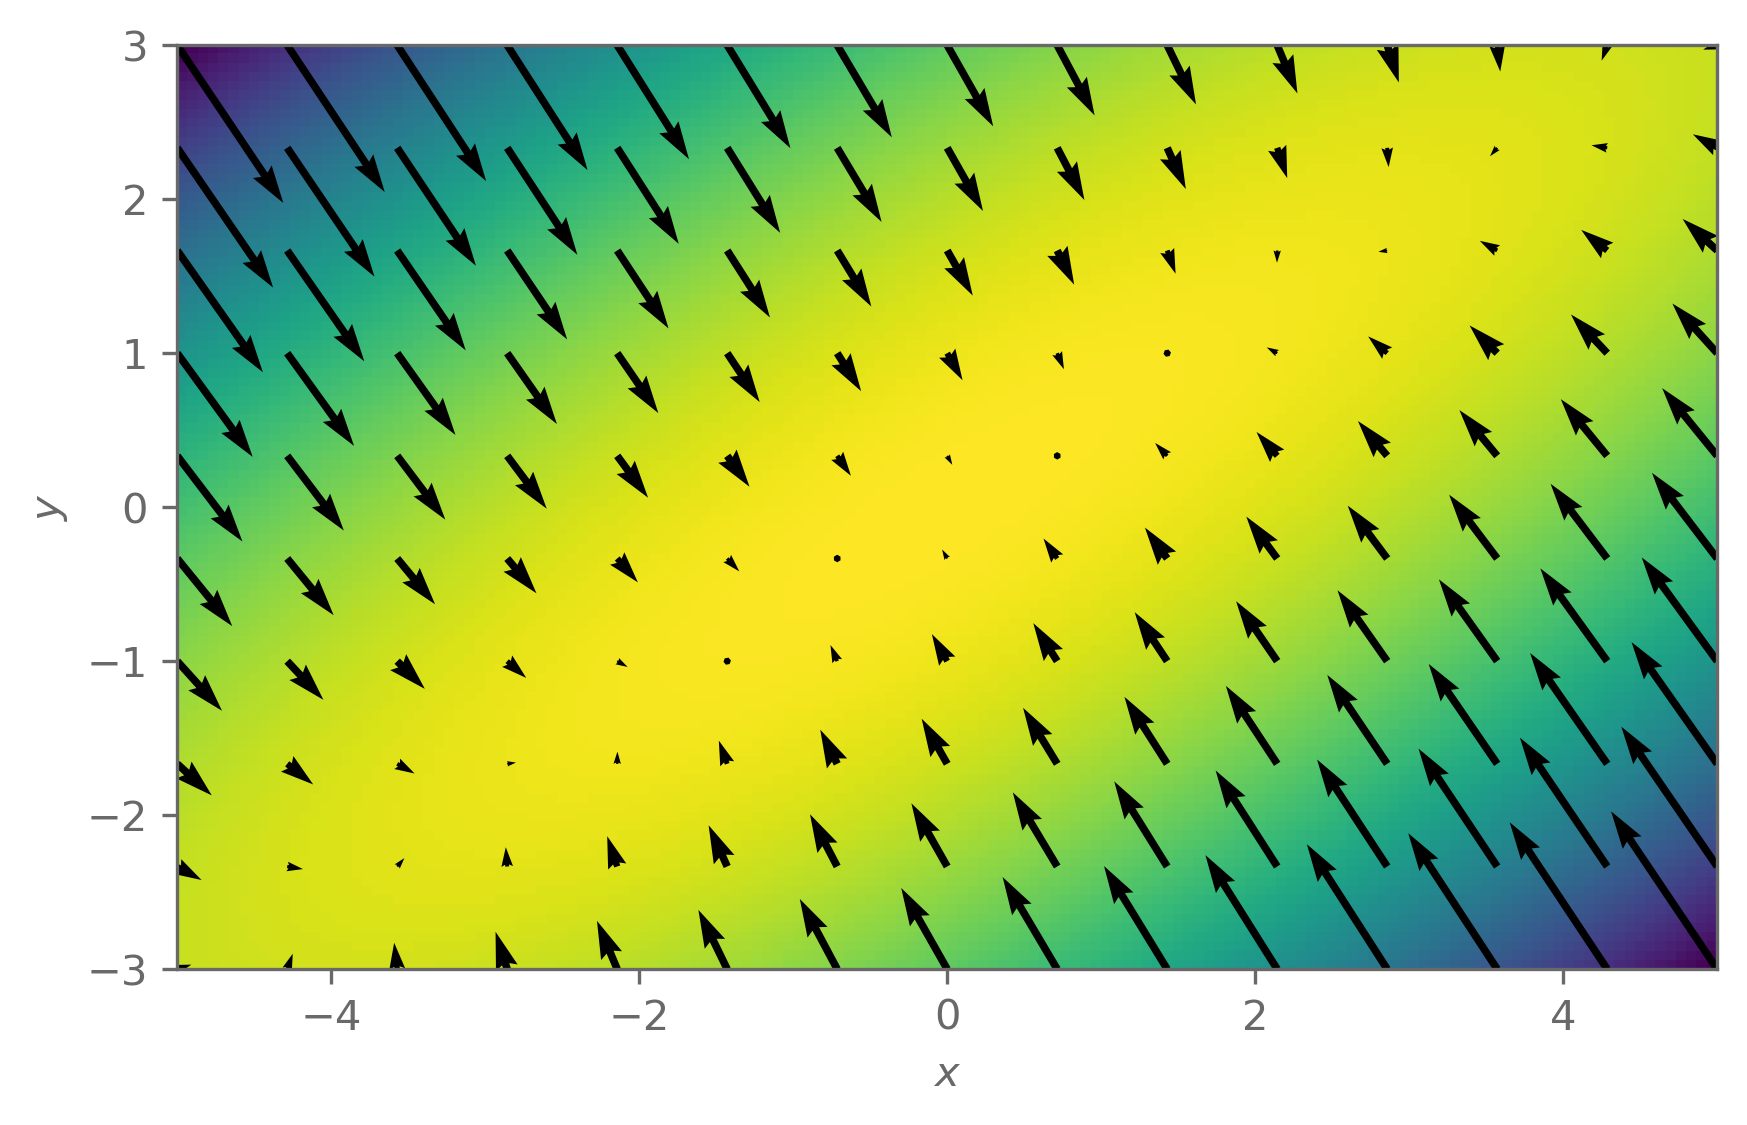

In [153]:
x_grid_fine = jnp.linspace(-5, 5, 150)
y_grid_fine = jnp.linspace(-3, 3, 100)
coords_fine = jnp.dstack(jnp.meshgrid(x_grid_fine, y_grid_fine)).reshape(-1, 2)

plt.imshow(
    vmap(log_pdf)(coords_fine).reshape(y_grid_fine.size, x_grid_fine.size),
    extent=(x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]), origin="lower")
plt.quiver(*coords.T, *grads.T)
plt.xlabel("$x$")
plt.ylabel("$y$");

## Exercises

Read the JAX tutorials.

Use JAX to confirm the Fisher information for the case of a Gaussian with either fixed mean or fixed variance.

Implement one of the likelihoods you have used so far (for example from the quadratic model fit exercise) in JAX and compute the Fisher information matrix.

## Hamiltonian Monte Carlo

Hamiltonian Monte Carlo is a MCMC algorithm that scales well to high dimensions. 

The downside is that it requires the derivative of the log probability. But with JAX we can get that easily now.

We define a Hamiltonian
$$
    H(\vec x, \vec p) = U(\vec x) + K(\vec p)
$$
with potential $U(\vec x)$ and kinetic energy $K(\vec p) = \vec p^T M^{-1}\vec p$, with mass matrix $M$.



From this we can define a probability
$$
    p_H(\vec x, \vec p) = \frac{1}{Z}\ee^{-H(\vec x, \vec p)} = \frac{1}{Z}\ee^{-U(\vec x)}\ee^{-K(\vec p)}
$$
The marginal distribution of $\vec x$ is then
$$
    p(\vec x) \propto \ee^{-U(\vec x)}
$$
This is the distribution we want to sample from. To do this, we define $U(\vec x) = -\log p(\vec x)$.

Hamiltonian dynamics are defined by the equations of motion
\begin{align}
    \frac{\dd x_i}{\dd t} &= \frac{\partial H}{\partial p_i} \\
    \frac{\dd p_i}{\dd t} &= -\frac{\partial H}{\partial x_i} \\
\end{align}

In our case we have
\begin{align}
    \frac{\dd x_i}{\dd t} &= \frac{\partial K}{\partial p_i} = (M^{-1}\vec p)_i \\
    \frac{\dd p_i}{\dd t} &= -\frac{\partial U}{\partial x_i} \\
\end{align}


Hamiltonian Monte Carlo works as follows:

Start at $\vec x_0$.
1. Sample $\vec p_0$ from a Gaussian with mean 0 and covariance $M$: $\vec p_0\sim\Norm(0, M)$
2. Evolve $\vec x$ and $\vec p$ with the dynamics defined by the Hamiltonian using the leap frog algorithm
3. Accept the new position using a Metropolis-Hastings acceptance criterion based on the integration error of the Hamiltonian



The leap frog algorithm works like this:
1. Evolve the momentum a half step: $\vec p_{t+\epsilon/2} = \vec p_\epsilon - \frac{\epsilon}{2}\nabla U(\vec x_t)$
2. Evolve the position by a full step: $\vec x_{t+\epsilon} = \vec x_t + \epsilon M^{-1} \vec p_{t+\epsilon/2}$
3. Evolve the momentum another half step: $\vec p_{t+\epsilon} = \vec p_{t+\epsilon/2} - \frac{\epsilon}{2}\nabla U(\vec x_{t+\epsilon})$

The acceptance probability is
$$
    a = \min\left(1, \frac{\ee^{-H(\vec x_\mathrm{new}, \vec p_\mathrm{new})}}{\ee^{-H(\vec x_\mathrm{old}, \vec p_\mathrm{old})}}\right)
$$

If the equations of motions are solved exactly, the Hamiltonian would be conserved, and the acceptance probability would always be 1.

In practice, we get an integration error, which depends on the step size $\epsilon$ and number of steps $L$. These are the main tuning parameters.

For the integration to be stable, $\epsilon$ needs to be smaller than the smallest length scale in the distribution we want to sample.

The number of steps should chosen such that $L\epsilon$ is long enough the cover the longest length scale.

In addition, the mass matrix $M$ can be chosen to align the momenta better with the shape of the distribution.

In [161]:
def sample_hmc(x0, log_pdf, n, L, epsilon, mass_matrix, key):

    mass_matrix_inv = jnp.linalg.inv(mass_matrix)

    # Define the potential and Hamiltonian
    def U(x):
        return -log_pdf(x)

    def H(x, p):
        return U(x) + 0.5 * p @ mass_matrix_inv @ p

    # Use JAX to get the gradient of U
    grad_x_U = grad(U)

    # The leap frog integrator. We speed this up using just-in-time compilation
    @jit
    def leap_frog(x, p):
        t = [x]
        for _ in range(L):
            p_prime = p - epsilon/2 * grad_x_U(x)
            x = x + epsilon * mass_matrix_inv @ p_prime
            p = p_prime - epsilon/2 * grad_x_U(x)
            t.append(x)
        return x, p, jnp.array(t)
    
    samples = [x0]
    trajectories = []
    n_accpeted = 0
    for _ in range(n):
        key, subkey = jax.random.split(key)
        # Sample a new momentum
        p0 = jax.random.multivariate_normal(
            subkey, mean=jnp.zeros_like(x0), cov=mass_matrix
        )
        # Integrate Hamiltonian dynamics
        x, p, t = leap_frog(x0, p0)

        # Metropolis-Hastings step
        a = min(1, jnp.exp(H(x0, p0) -  H(x, p)))

        key, subkey = jax.random.split(key)
        u = jax.random.uniform(subkey)
        if a >= u:
            x0 = x
            n_accpeted += 1
        
        samples.append(x0)
        trajectories.append(t)
    
    acceptance_rate = n_accpeted/n
    return jnp.array(samples), trajectories, acceptance_rate

In [166]:
# Setup our PRNG keys
key, subkey = jax.random.split(jax.random.PRNGKey(42))

samples, trajectories, acceptance_rate = sample_hmc(
    x0=jnp.array([0.0, 2.0]),
    log_pdf=log_pdf,
    n=30,
    L=20, epsilon=0.2, mass_matrix=jnp.eye(2),
    key=subkey
)
print(f"Acceptance rate: {acceptance_rate:.3f}")

Acceptance rate: 0.967


In [253]:
from matplotlib.collections import LineCollection
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots()

levels = 1-np.exp(-0.5*np.array([1, 2])**2)

def pdf(x):
    return jnp.exp(log_pdf(x))

ax.contour(
    vmap(pdf)(coords_fine).reshape(y_grid_fine.size, x_grid_fine.size)/pdf(mean),
    extent=(x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]), origin="lower",
    levels=(1-levels)[::-1], colors="grey", linewidths=1)

ax.set_xlim(-5, 5)
ax.set_ylim(-3, 3)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

trail_length = 10
alpha = np.linspace(0.0, 1, trail_length)[::-1]

artists = []

sample_points = []

for s, t in zip(samples, trajectories):
    sample_points += ax.plot(*s, marker="o", ms=3, c="C3")

    for i in range(t.shape[0]+trail_length//2):
        trail = t[max(0, i-trail_length): min(i, t.shape[0])]
        n = trail.shape[0]
        colors = np.zeros((n, 4))
        colors[:, 3] = alpha[:n][::-1]

        points = trail.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        collection = LineCollection(segments, colors=colors)
        
        artists.append(sample_points + [ax.add_collection(collection)])
    
hmc_sampling_ani = ArtistAnimation(fig, artists=artists, interval=70, blit=True)
plt.close()
# HTML(hmc_sampling_ani.to_jshtml())
hmc_sampling_ani.save(filename="../hmc.webp", writer="pillow")

![hmc](../assets/hmc.webp)

The tuning steps are important but can be tedious. Mature implemetations, such as the no-U-turn algorithm (NUTS) with automatic tuning are available.

Here is an implementation in `tensorflow_probability`. This works without the need for `tensorflow` thanks to the JAX backend.

In [167]:
import tensorflow_probability.substrates.jax as tfp

num_results = 2000
num_burnin_steps = 1000

# Set the adaptation strategy...
adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    # ... for the sampler, which is NUTS here
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=jax.jit(jax.vmap(log_pdf)), # The target distribution
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8) # How many steps to use for tuning
)

In [168]:
def run_chain(seed):
    # Run the chain (with burn-in).
    samples, info = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=jnp.array([0.0, 0.0]), 
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: (pkr.inner_results.target_log_prob, pkr.inner_results.is_accepted),
        seed=seed
    )

    log_prob, is_accepted = info
    print(f"Acceptance rate: {is_accepted.sum()/is_accepted.size}")
    return samples, log_prob

samples, log_prob = run_chain(seed=jax.random.PRNGKey(42))

Acceptance rate: 0.8647500276565552


## Exercises

Implement HMC yourself. 

Experiment with the step size, number of steps, and mass matrix.

Try an implementation of NUTS, for example the one in tensorflow probability shown earlier.